In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import os
# Disable Julia's signal handling to prevent crashes on macOS
os.environ["PYTHON_JULIACALL_HANDLE_SIGNALS"] = "no"
# Disable Julia's multithreading to prevent segfaults when signal handling is disabled
os.environ["PYTHON_JULIACALL_THREADS"] = "1"

from pysr import PySRRegressor
print("Loaded packages successfully.")

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
Loaded packages successfully.


generate synthetic data

In [2]:
X = np.linspace(-3, 3, 100).reshape(-1, 1)  # Input from -3 to 3

# The Secret Equation: y = 2.5*x^2 + cos(x)
y_truth = 2.5 * X**2 + np.cos(X)

THE BLACK BOX (The Neural Net)

Epoch 0: Loss 101.23473358154297
Epoch 200: Loss 0.48930659890174866
Epoch 400: Loss 0.06782940775156021
Epoch 600: Loss 0.019400211051106453
Epoch 800: Loss 0.00816144235432148
Epoch 600: Loss 0.019400211051106453
Epoch 800: Loss 0.00816144235432148


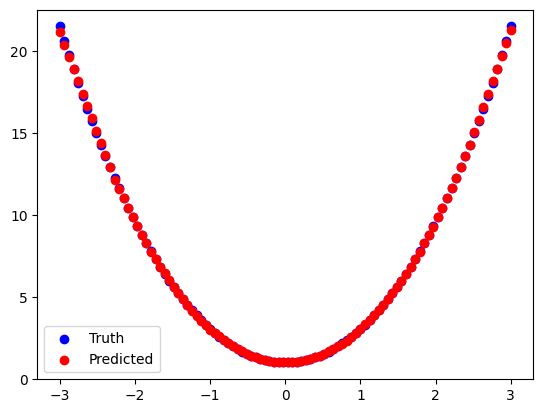

In [3]:
class BlackBox(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(1, 64)  # 64 Neurons
        self.output = nn.Linear(64, 1)  # 1 Output
        self.activation = nn.ReLU()     # Non-linear activation

    def forward(self, x):
        x = self.hidden(x)
        x = self.activation(x)
        return self.output(x)

model = BlackBox()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Convert numpy data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y_truth, dtype=torch.float32)

# Train the model
for epoch in range(1000):
    optimizer.zero_grad()
    y_pred = model(X_tensor)
    loss = criterion(y_pred, y_tensor)
    loss.backward()
    optimizer.step()
    
    if epoch % 200 == 0:
        print(f"Epoch {epoch}: Loss {loss.item()}")
# Plot the results
plt.scatter(X, y_truth, color='blue', label='Truth')
plt.scatter(X, y_pred.detach().numpy(), color='red', label='Predicted')
plt.legend()
plt.show()

GLASSBOX EXTRACTION


In [4]:
# Now we treat the Neural Net as the source of truth.
# We generate predictions from the Neural Net.
nn_predictions = model(X_tensor).detach().numpy()


In [5]:
nn_predictions[:5]

array([[21.1599  ],
       [20.40951 ],
       [19.659122],
       [18.90873 ],
       [18.15834 ]], dtype=float32)

In [6]:
# Initialize the Symbolic Regressor (The Translator)
# This tool tries to find an equation that matches the inputs to the NN's outputs.
glassbox = PySRRegressor(
    niterations=40,  # Search for 40 iterations
    binary_operators=["+", "*", "-", "/"],
    unary_operators=["cos", "exp", "sin", "square"],
    verbosity=0
)

# Fit GlassBox to the Neural Net's behavior
glassbox.fit(X, nn_predictions)

/Users/jeff/Desktop/glassbox/venv/lib/python3.9/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          7.6885524   
	1         0.136254                                         square(x0)   
	2         2.342204                             square(x0 * 1.5482423)   
	3         1.205392                 square(x0 * 1.5010391) + 0.7928632   
	4         1.837477                   cos(x0) + square(x0 * 1.5809245)   
	5         0.032591    cos(x0 * -0.9762573) + (square(x0) * 2.4935427)   
	6         0.020414  ((cos(x0) * 0.8733324) + 0.10600847) + square(...   
	7         0.655630  (square((-0.003914915 / sin(x0)) + x0) * 2.519...   
	8         0.020970  (square((-0.003914915 / sin(sin(x0))) + x0) * ...   
	9         0.000018  (square((-0.003914915 / sin(x0)) + x0) * 2.519...   
	10        0.020171  cos(x0) + (square((x0 + x0) + (-0.008678449 / ...   
	11        0.102391  square((-0.008138232 / sin(x0)) + ((x0 + x0) *...   
	12        0.002015  cos(x0 * 1.0277787) + square(((x0 + sin(-0.010...   
	13        0.092760  cos(x0 * 1.0467249) + (square((x0 + ((-0.01096...   
	14        0.006227  (square(((x0 + x0) + sin(-0.011390419 / sin(x0...   
	15        0.031516  square((-0.009375988 / sin(x0)) + ((x0 + x0) *...   
	16        0.005097  cos(sin(-0.014425124 / x0) + (x0 * 1.0428631))...   
	17        0.118755  (cos(((-0.014333957 / x0) + x0) * 1.0629213) +...   
	18        0.000942  (square(((-0.012823898 / sin(x0)) + (x0 + x0))...   
	19        0.002087  (square((-0.010330353 / sin(sin(x0))) + ((x0 +...   
	20        0.002818  cos((x0 * 1.0621089) + (-0.015238556 / sin(sin...   
	21  >>>>  0.201735  cos(((sin(square(x0)) * -0.026453983) + 1.0458...   
	22        0.001859  cos(((sin(square(x0)) * -0.026453983) + 1.0458...   
	23        0.014539  square((-0.010078559 / sin(x0)) + ((x0 + x0) *...   
	24        0.005016  square((-0.010078559 / sin(x0)) + ((x0 + x0) *...   
	
	         loss  complexity  
	0   38.059600           1  
	1   33.211594           2  
	2    0.306815           4  
	3    0.027535           6  
	4    0.004384           7  
	5    0.004107           9  
	6    0.003943          11  
	7    0.002047          12  
	8    0.002004          13  
	9    0.002004          14  
	10   0.001964          15  
	11   0.001773          16  
	12   0.001770          17  
	13   0.001613          18  
	14   0.001603          19  
	15   0.001553          20  
	16   0.001545          21  
	17   0.001372          22  
	18   0.001371          23  
	19   0.001368          24  
	20   0.001364          25  
	21   0.001115          26  
	22   0.001113          27  
	23   0.001081          29  
	24   0.001076          30  
]

RESULTS & COMPARISON


------------------------------------------------
THE REVEAL:
Original Secret Equation:  2.5 * x^2 + cos(x)
GlassBox Extracted Logic:  ((x0 + x0)*0.79716307 - 0.010182317/sin(x0))**2 + cos((1.0458121 + sin(x0**2)*(-0.026453983))*(x0 - 0.01365262/x0))
------------------------------------------------


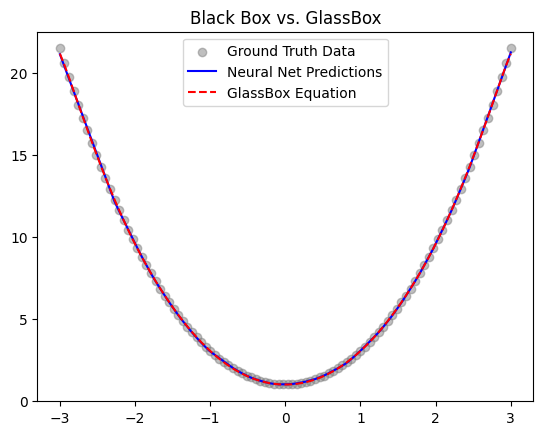

In [7]:
print("\n------------------------------------------------")
print("THE REVEAL:")
print(f"Original Secret Equation:  2.5 * x^2 + cos(x)")
print(f"GlassBox Extracted Logic:  {glassbox.sympy()}")
print("------------------------------------------------")

# Visualization
plt.scatter(X, y_truth, label='Ground Truth Data', color='gray', alpha=0.5)
plt.plot(X, nn_predictions, label='Neural Net Predictions', color='blue')
plt.plot(X, glassbox.predict(X), label='GlassBox Equation', color='red', linestyle='--')
plt.legend()
plt.title("Black Box vs. GlassBox")
plt.show()

 
**The "Bad" News (and why we need to engineer this further):**
Look at the text output.
*   **The Truth:** $2.5x^2 + \cos(x)$
*   **GlassBox found:** `((x0 + x0)*0.79... - .../sin(x0))**2 + ...`

The AI found a "Rube Goldberg" machine. It approximated $2.5x^2$ by doing `((x0 + x0) * 0.79...)^2` (which is roughly $(1.6x)^2 \approx 2.56x^2$). It got the right answer, but in a messy way. This is called **Bloat** in Symbolic Regression.
  
   